# 第9回: RNN: Exercise1
## Echo State Networksで神経活動を学習する
### 概要
本演習ではpythonを用いてEcho State Networksを実装します。

学習データセットとして、運動イメージの脳波データを用い、与えられた脳波から４つの運動イメージをデコードします。

まず、講師が概要を説明しますので、全体を掴んだところで演習に取り組んでください。

### 目標
- numpyでESNを実装する
- 神経活動を記録したデータ・セットを学習する
    - EEGから運動イメージを予測する

### 使用するデータセット
#### [Four class motor imagery](http://bnci-horizon-2020.eu/database/data-sets)

- [About this dataset](http://www.bbci.de/competition/iv/desc_1.html)
- Moter Imaginary Tasks(運動イメージタスク)
- 9人の被験者 (今回使用するのは一人)
- 以下の４つの運動イメージについてEEG(electroencephalogram: 脳波記録)を測定
    - [Class1] 右手
    - [Class2] 左手
    - [Class3] 両足
    - [Class4] 舌
- 実験は2session、それぞれ別日に行われた
- 一つのセッションは6回のテストから構成される
- 一つのテストは48試行から構成される
    - 12試行 * 4クラス
- 計: 6テスト * 48試行 = 288試行/人
- 各セッションのはじめに、EEG(脳波)に対するEOG(眼球運動)の影響を測定するため、5分間の計測を実施(Fig.1)
    - (1). 二分間fixation crossを凝視(眼球運動を固定)
    - (2). 一分間目をとじる
    - (3). 一分間目をあける(眼球運動を含む)
![mit](../images/mit.png)
- 試行の手続き(Fig.2)
    - (1). fixation cross + a short acoustic warning tone
    - (2). 手がかり(クラスを指し示した矢印の表示)
    - (3). 運動イメージの生成
    - (4). 休憩

![timing](../images/timing.png)

![elec](../images/elec.png)

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.io import loadmat

### データセットの確認

学習データと教師データを読み込んでみましょう。
25channelを収録、内はじめの22セットがEEG、残りの3セットがEOGとなります。

In [2]:
data_x = np.load('../data/ESN/eog1T.npy')  # train
data_y = np.load('../data/ESN/eog1Tt.npy')  # teacher

なお読み込んだデータセットは、`np.ndarray`オブジェクトとして格納されます。
このデータはEOGのセッションを含んでおり、実際の運動イメージタスクは4053サンプル目から始まります。

In [6]:
data_x.shape

(29683, 25)

今回はEOGのセッションは使わないので、運動イメージタスクが開始された直後からを学習データとします。

In [7]:
START = 4053
END = 29683
CHANNEL_SIZE = 6
_data = data_x[START:]
teacher = data_y[START:]

In [8]:
data = np.vstack((
    data_x[START:, 0],  # Fz
    data_x[START:, 7],  # C3
    data_x[START:, 9],  # Cz
    data_x[START:, 11], # C4
    data_x[START:, 19],  # Fz
    data_x[START:, 24],  # EOG
)).T
print(data.shape, teacher.shape)

(25630, 6) (25630,)


実際にデータを見てみましょう。

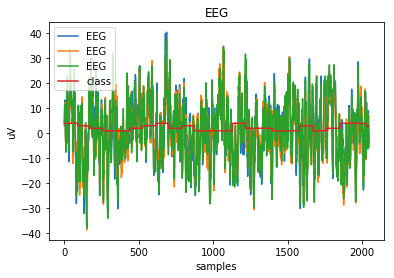

In [9]:
x = data_x[START:6100, :3]
y = data_y[START:6100]
plt.plot(x, label='EEG')
plt.plot(y, label='class')
plt.title('EEG')
plt.xlabel('samples')
plt.ylabel('uV')
plt.legend()
plt.show()

## ESNの実装
では、ESNの実装を始めましょう。今回は、任意の入力(25チャンネル)から、運動イメージのクラス(1チャンネル)を予測し出力します。

In [10]:
# load the data
testLen = 2000
trainLen = (END - START) - testLen
initLen = 1000

### ハイパーパラメータの設定

以下ではハイパーパラメータの設定を行います。
- 入力: `inSize`
- 出力: `outSize`
- 隠れ素子: `resSize`
- leaking rate: `a`

In [11]:
inSize = CHANNEL_SIZE  # Nu
outSize = 1  # Ny
resSize = 2000  # Nx
a = 0.3 # leaking rate

### Variableの設定

ネットワークで使用するパラメータの設定を行います。

In [12]:
np.random.seed(42)
# Win: (Nx, 1 + Nu)
# W: (Nx, Nx)
Win = (np.random.rand(resSize, 1 + inSize) - 0.5) * 1
W = np.random.rand(resSize, resSize) - 0.5 
W *= 0.135  # Magic!

In [13]:
# allocated memory for the design (collected states) matrix
# X: (1 + Nu + Nx, Nt)
X = np.zeros((1 + inSize + resSize, trainLen - initLen))

# set the corresponding target matrix directly
Yt = teacher[initLen + 1 : trainLen + 1] 

x = np.zeros((resSize,1))

各パラメータの`shape`は以下のようになります

In [14]:
print(Win.shape, W.shape, X.shape, Yt.shape, x.shape)

(2000, 7) (2000, 2000) (2007, 22630) (22630,) (2000, 1)


### Forwarding

では、データをネットワークにfeedします。

In [16]:
for t in range(trainLen):
    u = data[t].reshape(CHANNEL_SIZE, 1)
    x_tld = np.tanh(np.dot(Win, np.vstack((1, u))) + np.dot(W, x))
    x = (1 - a) * x + a * x_tld
    if t >= initLen:
        X[:, t - initLen] = np.vstack((1, u, x))[: ,0]

#### Hint
・行列同士の積は`np.dot()`を使用しましょう
```python
# EXAMPLE
>>> a = [[1, 0], [0, 1]]
>>> b = [[4, 1], [2, 2]]
>>> np.dot(a, b)
array([[4, 1],
       [2, 2]])
```

・tanh関数は`np.tanh()`を使用しましょう


・行列を垂直方向に重ねるには`numpy.vstack()`が便利です
```python
# EXAMPLE
>>> a = np.array([1, 2, 3])
>>> b = np.array([2, 3, 4])
>>> np.vstack((a,b))
array([[1, 2, 3],
       [2, 3, 4]])
       
>>> np.vstack((0, [[1], [2], [3]]))
array([[0],
       [1],
       [2],
       [3]])
```

<div class="alert alert-block alert-warning">
Warning:<br>
データをfeedする際にはたとえ一次元であっても、二次元で表記するべきです。
すなわち、列ベクトルのshapeは(25,)ではなく(25, 1)として計算することを心がけてください。
</div>

### 線形回帰

材料は揃いましたので、求める`Wout`を線形回帰で計算します。
逆行列の計算は`sp.liniag.pinv()`メソッドで実装できます。

In [17]:
# train the output
# Wout: (Ny, 1 + Nu + Nx)
Wout = np.dot(Yt, sp.linalg.pinv(X))

/Users/smatsumori/.virtualenvs/chainer3/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [179]:
# for L2 (advanced)
'''
reg = 1e-8  # regularization coefficient
X_T = X.T
Wout = np.dot(dot(Yt,X_T), sp.linalg.inv(np.dot(X, X_T) + 
                                   reg * np.eye(1 + inSize + resSize)))
'''

'\nreg = 1e-8  # regularization coefficient\nX_T = X.T\nWout = np.dot(dot(Yt,X_T), sp.linalg.inv(np.dot(X, X_T) + \n                                   reg * np.eye(1 + inSize + resSize)))\n'

<div class="alert alert-block alert-info">
Note:<br>
リッジ回帰をする場合は、上記のコードを実行してみましょう。
</div>

### 評価
以下では評価計算を行います。
実装はForwardingの部分と殆ど同じです。

In [18]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize, testLen))
u = data[trainLen].reshape(CHANNEL_SIZE, 1)
for t in range(testLen):
    x_tld = np.tanh(np.dot(Win, np.vstack((1, u))) + np.dot(W, x))
    x = (1 - a) * x + a * x_tld
    y = np.dot(Wout, np.vstack((1, u, x)))
    Y[:, t] = y
    # generative mode:
    # u = y
    ## this would be a predictive mode:
    u = data[trainLen + t].reshape(CHANNEL_SIZE, 1)

<div class="alert alert-block alert-info">
Note:<br>
ESNでは一度出力した結果を入力に戻し、再帰的に処理することでデータを生成することが出来ます(generative mode)。
今回は入力と出力の次元が違うのでそのような処理は出来ません。
</div>

MSE: 1.5637235216578411


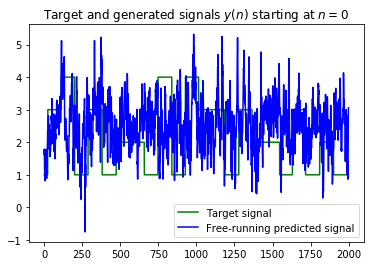

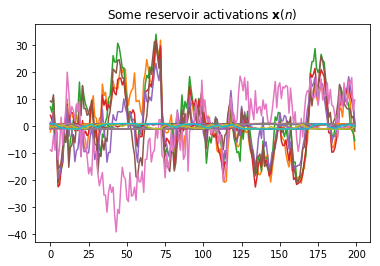

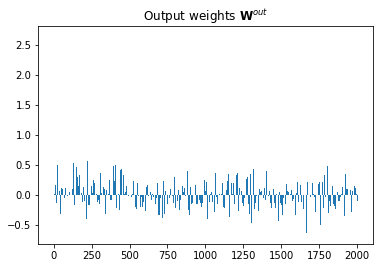

In [19]:
# compute MSE for the first errorLen time steps
errorLen = 500
ground_truth = teacher[trainLen + 1 : trainLen + errorLen + 1]
predicted = Y[:, 0:errorLen]
mse = np.mean(sum(np.square(ground_truth - predicted)))
print('MSE: {}'.format(mse))
    
# plot some signals
plt.figure(1).clear()
plt.plot(teacher[trainLen + 1 : trainLen + testLen + 1], 'g')
plt.plot(Y.T, 'b')
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot(X[0:20, 0:200].T)
plt.title('Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar(range(1 + inSize + resSize), Wout.T)
plt.title('Output weights $\mathbf{W}^{out}$')

plt.show()